In [ ]:
!pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install glpk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for glpk (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for glpk
Failed to build glpk
ERROR: Could not build wheels for glpk, which is required to install pyproject.toml-based projects


In [ ]:
%%capture
import sys
import os
import pyomo.environ as pyo
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
model = pyo.ConcreteModel()
model.x1 = pyo.Var(within=pyo.NonNegativeReals)
model.x2 = pyo.Var(within=pyo.NonNegativeReals)
model.obj = pyo.Objective(expr=model.x1 + 2 * model.x2, sense=pyo.minimize)
model.con1 = pyo.Constraint(expr=3 * model.x1 + 4 * model.x2 >= 1)
model.con2 = pyo.Constraint(expr=2 * model.x1 + 5 * model.x2 >= 2)
solver = pyo.SolverFactory('clp')
results = solver.solve(model)
print("Результаты:")
print("x1 =", model.x1())
print("x2 =", model.x2())
print("Значение целевой функции =", model.obj())

Результаты:
x1 = 0.0
x2 = 0.4
Значение целевой функции = 0.8


In [ ]:
m = 4
n = 5
a_data = {(i, j): random.randint(1, 100) for i in range(1, n+1) for j in range(1, m+1)}
b_data = {i: random.randint(1, 100) for i in range(1, n+1)}
c_data = {j: random.randint(1, 100) for j in range(1, m+1)}
print(a_data)
def obj_expression(model):
    return sum(model.c[j] * model.x[j] for j in model.J)
def ax_constraint_rule(model, i):
    return sum(model.a[i, j] * model.x[j] for j in model.J) >= model.b[i]
model = pyo.ConcreteModel()
model.m = pyo.Param(initialize=m, within=pyo.NonNegativeIntegers)
model.n = pyo.Param(initialize=n, within=pyo.NonNegativeIntegers)
model.I = pyo.RangeSet(1, model.n)
model.J = pyo.RangeSet(1, model.m)
model.a = pyo.Param(model.I, model.J, initialize=a_data)
model.b = pyo.Param(model.I, initialize=b_data)
model.c = pyo.Param(model.J, initialize=c_data)
model.x = pyo.Var(model.J, domain=pyo.NonNegativeReals)
model.OBJ = pyo.Objective(rule=obj_expression)
model.AxbConstraint = pyo.Constraint(model.I, rule=ax_constraint_rule)
solver = pyo.SolverFactory('clp')
solver.solve(model, tee=True)

print("Решение:")
for j in model.J:
    print(f"x[{j}] = {pyo.value(model.x[j])}")
print("Объекивная величина:", pyo.value(model.OBJ))



{(1, 1): 30, (1, 2): 15, (1, 3): 80, (1, 4): 72, (2, 1): 90, (2, 2): 82, (2, 3): 32, (2, 4): 88, (3, 1): 84, (3, 2): 96, (3, 3): 63, (3, 4): 43, (4, 1): 34, (4, 2): 4, (4, 3): 73, (4, 4): 40, (5, 1): 75, (5, 2): 34, (5, 3): 47, (5, 4): 20}
Coin LP version 1.17.8, build Jun  7 2023
command line - /content/bin/clp /tmp/tmp4j9bwvxa.pyomo.nl -AMPL 
CLP 1.17.8: Решение:
x[1] = 0.0
x[2] = 0.0
x[3] = 0.0
x[4] = 3.5000000000000004
Объекивная величина: 17.500000000000004


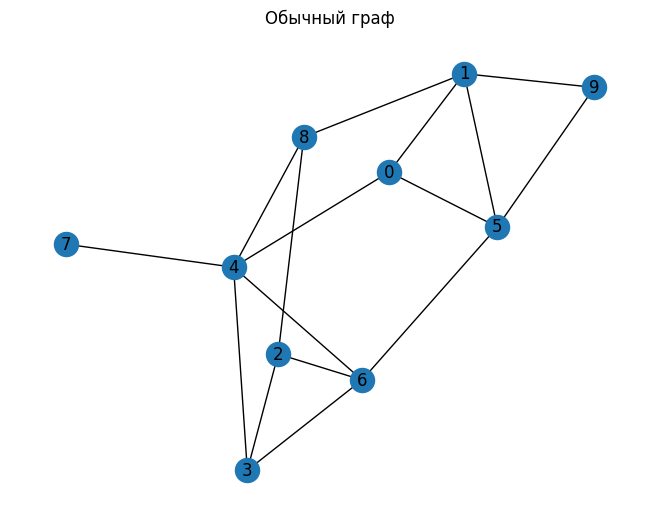

In [ ]:
from pyomo.environ import *
G = nx.Graph()
G.add_nodes_from(range(10))

for i in range(10):
    for j in range(i + 1, 10):
        if random.random() < 0.3:
            G.add_edge(i, j)

coloring = {}
nodes = sorted(G.nodes(), key=lambda x: -len(list(G.neighbors(x))))
for node in nodes:
    neighbors = set(G.neighbors(node))
    neighbor_colors = {coloring[n] for n in neighbors if n in coloring}
    for color in range(len(neighbors) + 1):
        if color not in neighbor_colors:
            coloring[node] = color
            break

node_colors = [coloring[node] for node in G.nodes()]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300)
plt.title("Обычный граф")
plt.show()

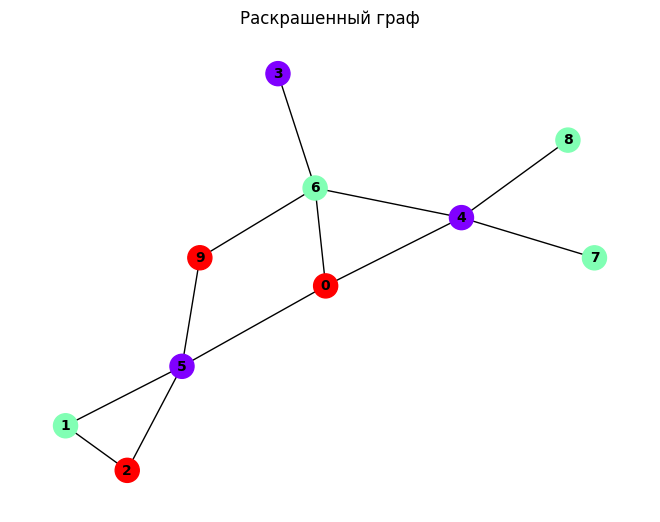

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, cmap=plt.cm.rainbow, font_size=10, font_color='black', font_weight='bold')
plt.title("Раскрашенный граф")
plt.show()


In [1]:
adjacency_matrix = nx.adjacency_matrix(G).toarray()


model = ConcreteModel()
vertices = list(G.nodes())
colors = list(set(node_colors))
model.x = Var(vertices, colors, within=Binary)

def one_color_rule(model, v, c):
    return sum(model.x[v, c] for c in colors) == 1
model.one_color_constraint = Constraint(vertices, colors, rule=one_color_rule)

def adjacent_colors_rule(model, u, v):
    return sum(model.x[u, c] + model.x[v, c] for c in colors) <= 1
model.adjacent_colors_constraint = Constraint(G.edges(), rule=adjacent_colors_rule)
color_matrix = np.zeros((len(vertices), len(colors)), dtype=int)
for v in vertices:
    for idx, c in enumerate(colors):
        if model.x[v, c].value is not None:
            color_matrix[v, idx] = int(model.x[v, c].value)
Y = len(list(G.nodes()))
print(Y)

def objective_rule(model):
    return sum(1 for v in vertices)
print(objective_rule(model))
model.objective = Objective(rule=objective_rule, sense=minimize)

solver = SolverFactory('glpk')
solver.solve(model)

NameError: ignored

In [ ]:
print("Результат оптимизации:")
for v in vertices:
    for c in colors:
        if model.x[v, c].value == 1:
            print(f"Вершина {v} покрашена в цвет {c}")

Результат оптимизации:
Вершина 0 покрашена в цвет 1
Вершина 1 покрашена в цвет 1
Вершина 3 покрашена в цвет 0
Вершина 6 покрашена в цвет 2
Вершина 7 покрашена в цвет 0
Вершина 8 покрашена в цвет 2
Вершина 9 покрашена в цвет 0


In [ ]:
color_matrix = np.zeros((len(vertices), len(colors)), dtype=int)
for v in vertices:
    for idx, c in enumerate(colors):
        color_matrix[v, idx] = int(model.x[v, c].value)

print("Матрица смежностей:\n",adjacency_matrix)

Матрица смежностей:
 [[0 1 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 1]
 [0 0 0 1 0 0 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 1 1 1 0]
 [1 1 0 0 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]]


In [ ]:
print("Матрица цветов:\n", color_matrix)

Матрица цветов:
 [[0 1 0]
 [0 1 0]
 [0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]]


In [ ]:
print("Y = ", len(set(node_colors)))

Y =  3
